# Tutorial: Quantization Behavior Flips

Audience:
- ML students or engineers who want an intuition for how low-bit quantization can change discrete model behavior.

Prerequisites:
- Basic Python
- Familiarity with linear models and classification

Learning goals:
- Understand how quantization perturbs model parameters
- See how small perturbations can flip discrete predictions near decision boundaries
- Build intuition for why safety behaviors can regress after quantization

## Outline

1. Setup
2. Build a tiny classifier
3. Quantize the weights
4. Measure behavior flips
5. Visualize decision boundaries
6. Sweep bit width
7. Exercises

In [1]:
# Setup: keep it deterministic and lightweight
import numpy as np
import matplotlib.pyplot as plt

SEED = 21
rng = np.random.default_rng(SEED)

## Step 1 - Build a tiny "safety" classifier

We model a binary decision (e.g., refuse vs comply) with a linear classifier. Points near the boundary are
fragile: small weight changes can flip the decision.

In [2]:
# Simple 2D linear model: y = sign(w @ x + b)
w = np.array([1.3, -0.9])
b = 0.05

# Create a grid of inputs
xs = np.linspace(-2.0, 2.0, 200)
ys = np.linspace(-2.0, 2.0, 200)
xx, yy = np.meshgrid(xs, ys)
X = np.stack([xx.ravel(), yy.ravel()], axis=1)

logits = X @ w + b
pred = (logits >= 0).astype(int)

w, b, pred.mean()

(array([ 1.3, -0.9]), 0.05, np.float64(0.509425))

## Step 2 - Quantize the weights

We apply symmetric uniform quantization to the weights. Lower bit widths introduce larger rounding error.

In [5]:
w,b

(array([ 1.3, -0.9]), 0.05)

In [3]:
def quantize_symmetric(x, bits=4):
    """Uniform symmetric quantization to int levels, then de-quantize."""
    if bits < 2:
        raise ValueError("bits must be >= 2")
    qmax = 2 ** (bits - 1) - 1
    scale = np.max(np.abs(x)) / qmax if np.max(np.abs(x)) > 0 else 1.0
    q = np.round(x / scale)
    q = np.clip(q, -qmax, qmax)
    return q * scale

w_q4 = quantize_symmetric(w, bits=4)
w_q3 = quantize_symmetric(w, bits=3)
w_q2 = quantize_symmetric(w, bits=2)

w, w_q4, w_q3, w_q2

(array([ 1.3, -0.9]),
 array([ 1.3       , -0.92857143]),
 array([ 1.3       , -0.86666667]),
 array([ 1.3, -1.3]))

## Step 3 - Measure behavior flips

A behavior flip is a change in the discrete prediction after quantization.

In [6]:
def predict(X, w, b):
    return (X @ w + b >= 0).astype(int)

def flip_rate(wq):
    pred_q = predict(X, wq, b)
    flips = (pred_q != pred).sum()
    return flips / pred.size

for bits in [8, 6, 4, 3, 2]:
    wq = quantize_symmetric(w, bits=bits)
    print(bits, "bits -> flip rate:", round(flip_rate(wq), 4))

8 bits -> flip rate: 0.0001
6 bits -> flip rate: 0.0038
4 bits -> flip rate: 0.0055
3 bits -> flip rate: 0.0064
2 bits -> flip rate: 0.0769


## Step 4 - Visualize decision boundary shifts

We plot the original boundary and the quantized boundary, highlighting points that flip.

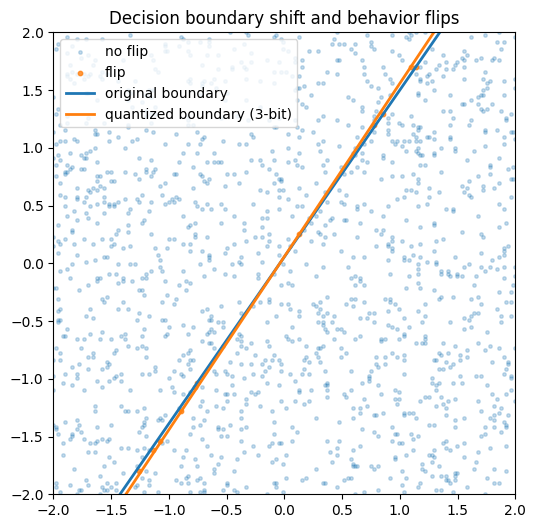

In [7]:
# Choose a bit width to visualize
bits = 3
wq = quantize_symmetric(w, bits=bits)

pred_q = predict(X, wq, b)
flip_mask = pred_q != pred

# Sample a subset for plotting clarity
idx = rng.choice(len(X), size=1500, replace=False)
X_s = X[idx]
flip_s = flip_mask[idx]

plt.figure(figsize=(6, 6))

# Plot flipped points
plt.scatter(X_s[~flip_s, 0], X_s[~flip_s, 1], s=6, alpha=0.25, label="no flip")
plt.scatter(X_s[flip_s, 0], X_s[flip_s, 1], s=10, alpha=0.8, label="flip")

# Decision boundaries: w1 x + w2 y + b = 0
x_line = np.linspace(-2, 2, 100)

y_orig = (-w[0] * x_line - b) / w[1]
y_q = (-wq[0] * x_line - b) / wq[1]

plt.plot(x_line, y_orig, label="original boundary", linewidth=2)
plt.plot(x_line, y_q, label=f"quantized boundary ({bits}-bit)", linewidth=2)

plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title("Decision boundary shift and behavior flips")
plt.show()

## Step 5 - Sweep bit width

We measure how flip rate grows as bit width decreases.

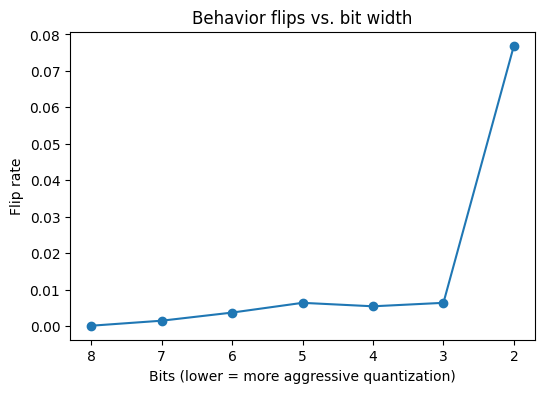

[(2, np.float64(0.0769)),
 (3, np.float64(0.0064)),
 (4, np.float64(0.0055)),
 (5, np.float64(0.0064)),
 (6, np.float64(0.0038)),
 (7, np.float64(0.0015)),
 (8, np.float64(0.0001))]

In [8]:
bitwidths = list(range(2, 9))
flip_rates = [flip_rate(quantize_symmetric(w, bits=b)) for b in bitwidths]

plt.figure(figsize=(6, 4))
plt.plot(bitwidths, flip_rates, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("Bits (lower = more aggressive quantization)")
plt.ylabel("Flip rate")
plt.title("Behavior flips vs. bit width")
plt.show()

list(zip(bitwidths, [round(fr, 4) for fr in flip_rates]))

## What this says about quantized LLMs

- Safety behaviors often depend on margins between refusing and complying.
- Quantization perturbs weights and activations, which can shift those margins.
- Inputs near the decision boundary are most vulnerable to flipping.

This toy example mirrors what can happen when an aligned model is quantized: refusal behavior can regress,
not because the model is malicious, but because the safety boundary moved.

## Exercises

1. Change the bias `b` to move the boundary. How does flip rate change?
2. Replace the linear model with a tiny 2-layer MLP and repeat the experiment.
3. Add activation quantization: quantize the intermediate activations before classification.

In [ ]:
# Exercise scaffold: add activation quantization for a 2-layer MLP

# TODO: implement a small 2-layer MLP and quantize its hidden activations
# Hint: use tanh or ReLU, then apply quantize_symmetric on the hidden activations

pass

## Pitfalls and extensions

- Pitfall: if you only test on easy inputs far from the boundary, you will miss flips.
- Extension: use a real local model and compare refusal rates before and after quantization.